# Burst Fitting example using BurstFit class

In [18]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn_vec, sgram_fn_vec, gauss_norm, gauss_2d
from burstfit.io import BurstIO
import logging
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=logging_format,
)

In [20]:
#fil_file = '../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil' # test data provided
#fil_file = '/data/dsa110/T1/corr02/2021_9_19_23_15_35/fil_210920aaai/210920aaai_98.fil' # our data (beam 98)
#fil_file = "/home/ubuntu/gechen/fake_data/test_1beams_10s.fil"
fil_file='/data/dsa110/T1/corr09/2021_10_8_0_29_27/fil_211009aacy/211009aacy_174.fil'
save_name = '211009aacy_174'

In [21]:
# fil_211009aacy 
bd = BurstData(
    fp=fil_file,
    dm=56.2,
    tcand=0.5, # pulse starting time in s.
    width=4, # width = 4 or 2^4 in time sample?  
    snr=27.0, 
    #kill_mask=np.array([False]),
    #min_samp=4./256-6
)

### check data 

In [22]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/home/ubuntu/proj/dsa110-shell/dsa110-T3/dsaT3/')
# import filplot_funcs as ff

sys.path.insert(1, '/home/ubuntu/gechen/software')
import filplot_funcs_gc as ff

In [23]:
nbin = 4
nfreq_plot = int(256/nbin)
print(nfreq_plot)

64


In [24]:
data, datadm, tsdm0, dms, datadm0 = ff.proc_cand_fil(fil_file, bd.dm, bd.width, nfreq_plot=nfreq_plot, ndm=32)

In [25]:
data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)]
print(nfreq_plot)

64


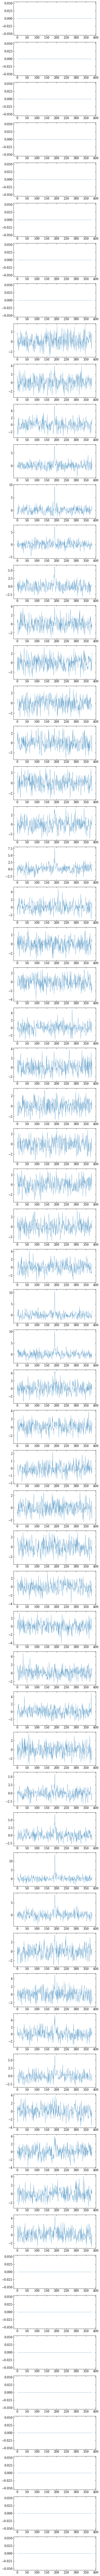

In [26]:
fig, ax = plt.subplots(nfreq_plot, 1, figsize=(6, 3*nfreq_plot))
for i in range(nfreq_plot):
    ax[i].plot(range(np.shape(data_burst)[1]), data_burst[i, :])

### check averaged lcv and spectrum 

(64, 15258)
15258.789062499998


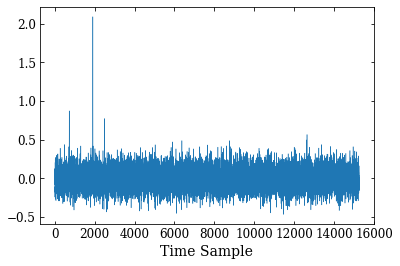

In [27]:
%matplotlib inline

plt.plot(range(len(data.mean(0))), data.mean(0))
plt.xlabel('Time Sample')

print(np.shape(data))
print(4./bd.tsamp) # /bd.width 4s per gulp, do not rebin by the pulse width 

Text(0.5, 0, 'Channels (binned)')

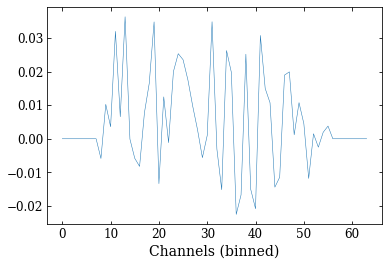

In [28]:
plt.plot(data.mean(1))
plt.xlabel('Channels (binned)')

## Fitting using BurstFit

In `BurstFit`, the fitting procedure for each component is as follows: 
1. Fit the profile using `curve_fit` and a profile model
2. Find the spectra using profile fit parameters
3. Fit the spectra using `curve_fit` and spectra model 
4. Use the profile and spectra fit parameters as initial guess and fit the 2D spectrogram using `curve_fit` and spectrogram model 

Therefore, `BurstFit` requires three functions: profile function, spectra function and spectrogram function. It is assumed that spectrogram function will use profile and spectra functions to make the spectrogram.   

Use the `Model` class to make profile and spectra models. You can optionally give names of the input parameters. These parameter names are used by `BurstFit` to automatically set relevant fitting bounds and priors.  

In [29]:
# For pulse, we will use a gaussian_dm convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel
# t, S, delta_dm, t0, sigma, tau

# pnames = ['S', 'delta_dm', 't0', 'sigma_t', 'tau']
# pulseModel = Model(pulse_fn_vec_dm, param_names=pnames)

# # For spectra, we will use a normalized gaussian model  
# snames = ['mu_f', 'sigma_f']
# spectraModel = Model(gauss_norm, param_names=snames)

In [30]:
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)

# For spectra, we will use a normalized gaussian model  
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)

Now we create a spectrogram model using `SgramModel` class, with the above two models and a spectrogram function (`sgram_fn_vec`)

### Select data near the burst time for fittings

In [31]:
sgram_mask = np.full(np.shape(data_burst), False)

In [32]:
sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])


Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 

In [33]:
bf = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, #bd.sgram not working 
    width=bd.width,
    dm=bd.dm,
    foff=bd.foff * 1024 / nfreq_plot,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask 
)

In [34]:
# Some setting up before we do the fitting 
bf.validate()
bf.precalc()

The fit results are saved as a dictionary of dictionaries. The keys of the dictionary are component numbers. For each component, the dictionary consists of keys: `popt` and `perr`, representing the fitted parameters and their 1-sigma errors. 

So, let's fit one component:

### Profile Fit

2021-12-09 02:29:10,316 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-12-09 02:29:10,349 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2021-12-09 02:29:10,351 - initial_profilefit -burstfit.fit - INFO - S: 616.5570042719603 +- 29.045668269180563
2021-12-09 02:29:10,351 - initial_profilefit -burstfit.fit - INFO - mu_t: 189.63151980471997 +- 0.19389976761091213
2021-12-09 02:29:10,352 - initial_profilefit -burstfit.fit - INFO - sigma_t: 1.351143688528958 +- 0.157944417353334
2021-12-09 02:29:10,353 - initial_profilefit -burstfit.fit - INFO - tau: 1.708089701376779 +- 0.3511571671203643


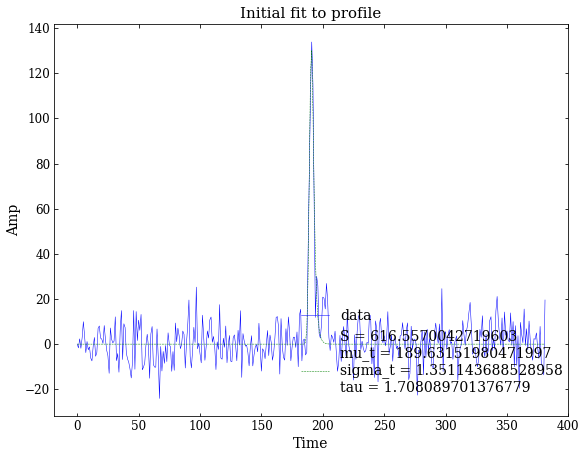

In [35]:
plot = True
profile_bounds=[]#((0, 0, 0, -np.inf),(np.inf, np.inf, np.inf, np.inf)) # did not work when only set up bounds but do not chop data 
bf.initial_profilefit(plot=plot, bounds=profile_bounds)

### Spectra Fit

In [36]:
bf.make_spectra()

2021-12-09 02:29:10,927 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.


2021-12-09 02:29:10,938 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-12-09 02:29:10,951 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-12-09 02:29:10,952 - initial_spectrafit -burstfit.fit - INFO - mu_f: 27.257221857820817 +- 4.791575263449345
2021-12-09 02:29:10,953 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 19.916568878902883 +- 3.9820764590961995


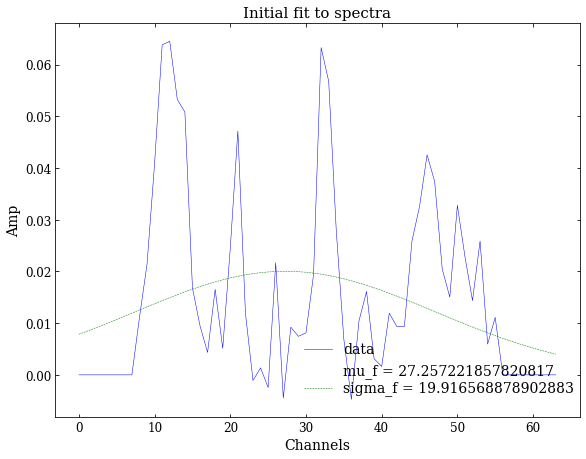

In [37]:
bf.initial_spectrafit(plot=plot)

Let's look at the profile and spectra fit parameters we just obtained 
(these were also printed in the logs above)

In [38]:
bf.profile_params

{1: {'popt': [616.5570042719603,
   189.63151980471997,
   1.351143688528958,
   1.708089701376779],
  'perr': array([29.04566827,  0.19389977,  0.15794442,  0.35115717])}}

In [39]:
bf.spectra_params

{1: {'popt': [27.257221857820817, 19.916568878902883],
  'perr': array([4.79157526, 3.98207646])}}

Now the above parameters will be used as initial guess to do sgram fitting. 

### Spectrogram Fit

2021-12-09 02:29:11,200 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-12-09 02:29:11,201 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [27.257221857820817, 19.916568878902883, 616.5570042719603, 189.63151980471997, 1.351143688528958, 1.708089701376779, 56.2]
2021-12-09 02:29:11,477 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-12-09 02:29:11,478 - sgram_fit -burstfit.fit - INFO - mu_f: 34.73585108902285 +- 1.5000530864733668
2021-12-09 02:29:11,479 - sgram_fit -burstfit.fit - INFO - sigma_f: 24.612076376753794 +- 2.0050822663836643
2021-12-09 02:29:11,480 - sgram_fit -burstfit.fit - INFO - S: 722.8238700538578 +- 48.90687177278048
2021-12-09 02:29:11,481 - sgram_fit -burstfit.fit - INFO - mu_t: 189.31504794431328 +- 0.33270706119006105
2021-12-09 02:29:11,481 - sgram_fit -burstfit.fit - INFO - sigma_t: 1.4476834946208934 +- 0.15853097972087968
2021-12-09 02:29:11,482 - sgram_fit -burstfit.fit - INFO - tau: 0

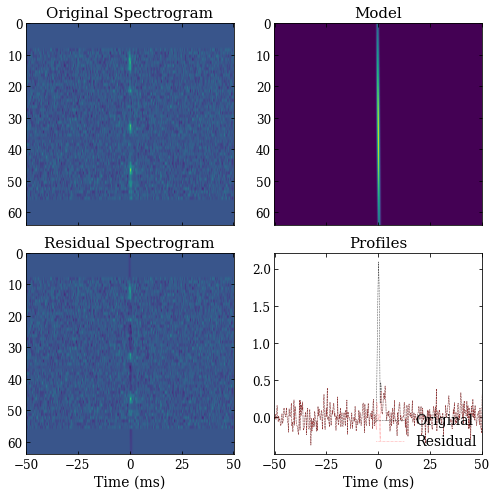

2021-12-09 02:29:12,208 - model -burstfit.fit - INFO - Making model.
2021-12-09 02:29:12,209 - model -burstfit.fit - INFO - Found 1 components.


In [40]:
bf.sgram_fit(plot=plot)

We can see the reduced chi square value of our sgram_fit too

In [41]:
bf.calc_redchisq()

2021-12-09 02:29:12,219 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-12-09 02:29:12,220 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-12-09 02:29:12,222 - model -burstfit.fit - INFO - Making model.
2021-12-09 02:29:12,223 - model -burstfit.fit - INFO - Found 1 components.
2021-12-09 02:29:12,229 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0366877053295134


1.0366877053295134

The fit parameters can be accessed using bf.sgram_params. It shows only one component as we only did one component fitting.

In [42]:
bf.sgram_params

{1: {'popt': [34.73585108902285,
   24.612076376753794,
   722.8238700538578,
   189.31504794431328,
   1.4476834946208934,
   0.44858362970693816,
   57.03437382939629],
  'perr': array([ 1.50005309,  2.00508227, 48.90687177,  0.33270706,  0.15853098,
          0.32297098,  0.12644461])}}

## fitcycle()

All the above steps have also been wrapped with fitcycle() 

2021-12-09 02:29:12,250 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2021-12-09 02:29:12,251 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-12-09 02:29:12,282 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2021-12-09 02:29:12,284 - initial_profilefit -burstfit.fit - INFO - S: 616.5570042719603 +- 29.045668269180563
2021-12-09 02:29:12,285 - initial_profilefit -burstfit.fit - INFO - mu_t: 189.63151980471997 +- 0.19389976761091213
2021-12-09 02:29:12,286 - initial_profilefit -burstfit.fit - INFO - sigma_t: 1.351143688528958 +- 0.157944417353334
2021-12-09 02:29:12,288 - initial_profilefit -burstfit.fit - INFO - tau: 1.708089701376779 +- 0.3511571671203643


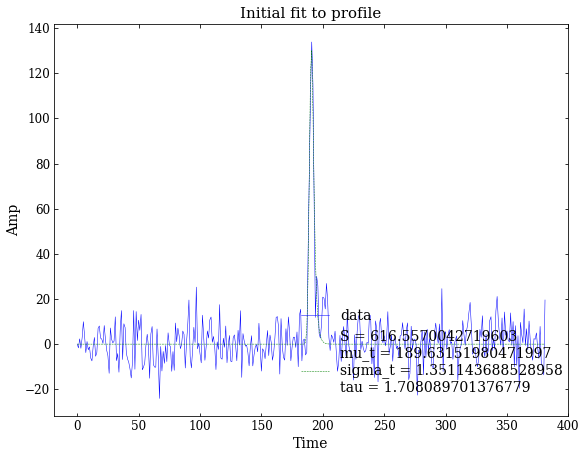

2021-12-09 02:29:12,544 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-12-09 02:29:12,546 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-12-09 02:29:12,556 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-12-09 02:29:12,557 - initial_spectrafit -burstfit.fit - INFO - mu_f: 27.257221857820817 +- 4.791575263449345
2021-12-09 02:29:12,558 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 19.916568878902883 +- 3.9820764590961995


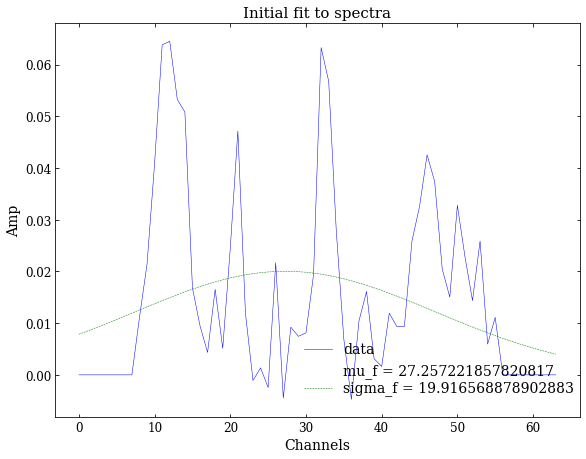

2021-12-09 02:29:12,767 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-12-09 02:29:12,769 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [27.257221857820817, 19.916568878902883, 616.5570042719603, 189.63151980471997, 1.351143688528958, 1.708089701376779, 56.2]
2021-12-09 02:29:13,010 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-12-09 02:29:13,011 - sgram_fit -burstfit.fit - INFO - mu_f: 34.73585108902285 +- 1.5000530864733668
2021-12-09 02:29:13,012 - sgram_fit -burstfit.fit - INFO - sigma_f: 24.612076376753794 +- 2.0050822663836643
2021-12-09 02:29:13,013 - sgram_fit -burstfit.fit - INFO - S: 722.8238700538578 +- 48.90687177278048
2021-12-09 02:29:13,014 - sgram_fit -burstfit.fit - INFO - mu_t: 189.31504794431328 +- 0.33270706119006105
2021-12-09 02:29:13,014 - sgram_fit -burstfit.fit - INFO - sigma_t: 1.4476834946208934 +- 0.15853097972087968
2021-12-09 02:29:13,015 - sgram_fit -burstfit.fit - INFO - tau: 0

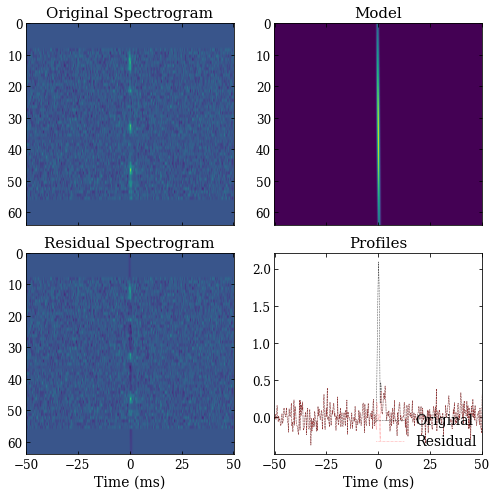

2021-12-09 02:29:13,602 - model -burstfit.fit - INFO - Making model.
2021-12-09 02:29:13,603 - model -burstfit.fit - INFO - Found 1 components.
2021-12-09 02:29:13,607 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-12-09 02:29:13,608 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-12-09 02:29:13,610 - model -burstfit.fit - INFO - Making model.
2021-12-09 02:29:13,610 - model -burstfit.fit - INFO - Found 1 components.
2021-12-09 02:29:13,615 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0366877053295134


In [43]:
bf.fitcycle(plot=True) #profile_bounds=[450, 550]

## fitall()

But `fitcycle()` only fits for one component. `BurstFit` can automatically fit for multiple components as well. For that we will use `fitall()`

Here it calls `fitcycle()` to fit for a component and then compares the ON-pulse residual with the OFF pulse regions (both left and right). If the distributions are similar then fitting is terminated. If the distributions aren't similar, then it tries to fit for another component. In the end, it will fit for all the components together. 

2021-12-09 02:29:13,627 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-12-09 02:29:13,628 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-12-09 02:29:13,647 - tests -root - INFO - P values: T-test (0.55144), Kruskal (0.35204), KS (0.73246), F-test (0.95659)
2021-12-09 02:29:13,648 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2021-12-09 02:29:13,654 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00000), F-test (0.00000)
2021-12-09 02:29:13,655 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2021-12-09 02:29:13,659 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00000), F-test (0.00000)
2021-12-09 02:29:13,660 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2021-12-09 02:29:13,661 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-12-09 02:29:13,684 - initial_profilefi

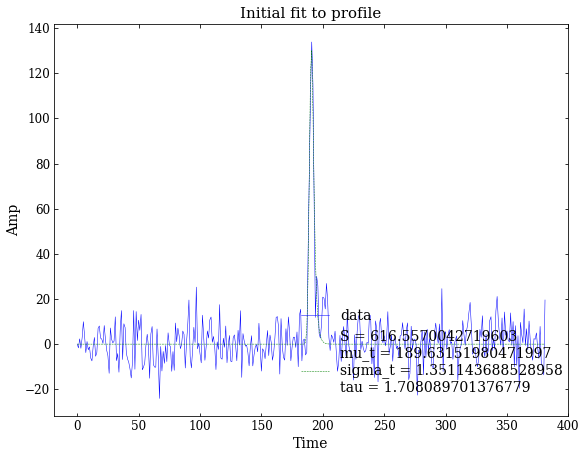

2021-12-09 02:29:13,954 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-12-09 02:29:13,956 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-12-09 02:29:13,965 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-12-09 02:29:13,966 - initial_spectrafit -burstfit.fit - INFO - mu_f: 27.257221857820817 +- 4.791575263449345
2021-12-09 02:29:13,967 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 19.916568878902883 +- 3.9820764590961995


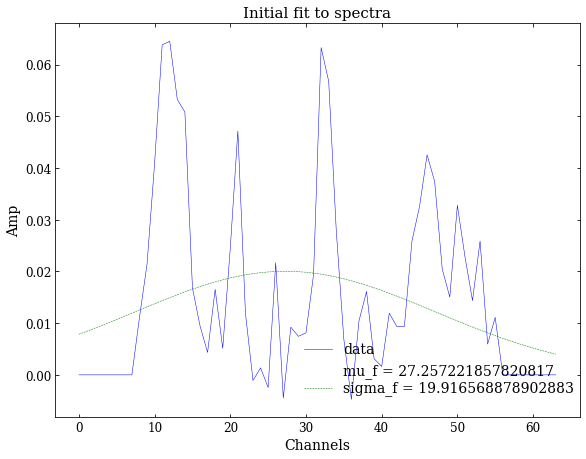

2021-12-09 02:29:14,197 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-12-09 02:29:14,199 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [27.257221857820817, 19.916568878902883, 616.5570042719603, 189.63151980471997, 1.351143688528958, 1.708089701376779, 56.2]
2021-12-09 02:29:14,538 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-12-09 02:29:14,541 - sgram_fit -burstfit.fit - INFO - mu_f: 34.73585108902285 +- 1.5000530864733668
2021-12-09 02:29:14,542 - sgram_fit -burstfit.fit - INFO - sigma_f: 24.612076376753794 +- 2.0050822663836643
2021-12-09 02:29:14,543 - sgram_fit -burstfit.fit - INFO - S: 722.8238700538578 +- 48.90687177278048
2021-12-09 02:29:14,544 - sgram_fit -burstfit.fit - INFO - mu_t: 189.31504794431328 +- 0.33270706119006105
2021-12-09 02:29:14,545 - sgram_fit -burstfit.fit - INFO - sigma_t: 1.4476834946208934 +- 0.15853097972087968
2021-12-09 02:29:14,545 - sgram_fit -burstfit.fit - INFO - tau: 0

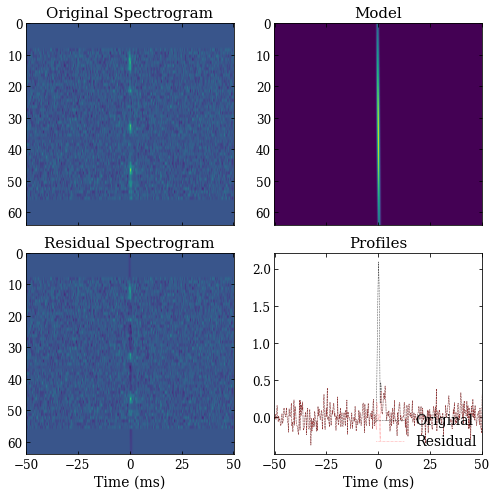

2021-12-09 02:29:15,105 - model -burstfit.fit - INFO - Making model.
2021-12-09 02:29:15,106 - model -burstfit.fit - INFO - Found 1 components.
2021-12-09 02:29:15,111 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-12-09 02:29:15,112 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-12-09 02:29:15,113 - model -burstfit.fit - INFO - Making model.
2021-12-09 02:29:15,114 - model -burstfit.fit - INFO - Found 1 components.
2021-12-09 02:29:15,120 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0366877053295134
2021-12-09 02:29:15,121 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-12-09 02:29:15,122 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-12-09 02:29:15,127 - tests -root - INFO - P values: T-test (0.55144), Kruskal (0.35204), KS (0.73246), F-test (0.95659)
2021-12-09 02:29:15,128 - run

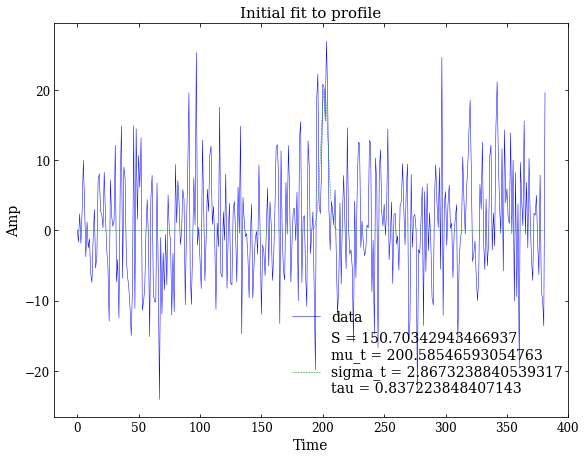

2021-12-09 02:29:15,403 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-12-09 02:29:15,405 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 2
2021-12-09 02:29:15,414 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-12-09 02:29:15,414 - initial_spectrafit -burstfit.fit - INFO - mu_f: 35.86750953633956 +- 6.5567945258731
2021-12-09 02:29:15,416 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 17.52817493670537 +- 5.504203150284136


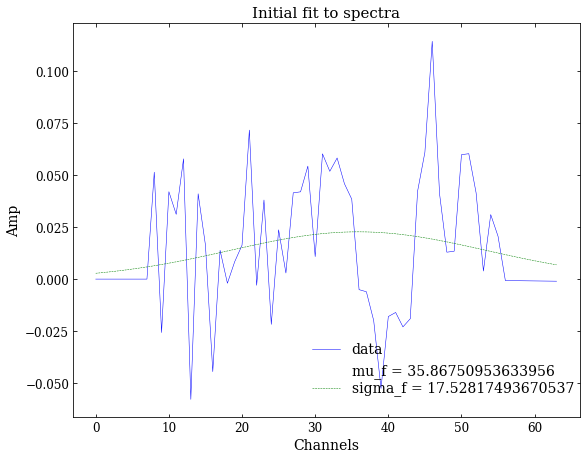

2021-12-09 02:29:15,649 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 2
2021-12-09 02:29:15,650 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [35.86750953633956, 17.52817493670537, 150.70342943466937, 200.58546593054763, 2.8673238840539317, 0.837223848407143, 56.2]
2021-12-09 02:29:15,866 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-12-09 02:29:15,867 - sgram_fit -burstfit.fit - INFO - mu_f: 39.31144486739021 +- 4.389934491506693
2021-12-09 02:29:15,868 - sgram_fit -burstfit.fit - INFO - sigma_f: 18.72900749773137 +- 5.131524681104195
2021-12-09 02:29:15,869 - sgram_fit -burstfit.fit - INFO - S: 150.53359149662865 +- 32.739645373444205
2021-12-09 02:29:15,869 - sgram_fit -burstfit.fit - INFO - mu_t: 198.66609898455815 +- 0.23217229123112992
2021-12-09 02:29:15,870 - sgram_fit -burstfit.fit - INFO - sigma_t: 1.821567830713908 +- 0.0057568852592236874
2021-12-09 02:29:15,872 - sgram_fit -burstfit.fit - INFO - tau: 0

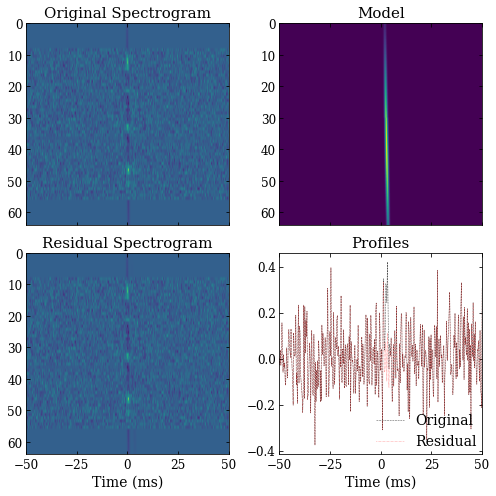

2021-12-09 02:29:16,499 - model -burstfit.fit - INFO - Making model.
2021-12-09 02:29:16,500 - model -burstfit.fit - INFO - Found 2 components.
2021-12-09 02:29:16,504 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-12-09 02:29:16,505 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-12-09 02:29:16,507 - model -burstfit.fit - INFO - Making model.
2021-12-09 02:29:16,508 - model -burstfit.fit - INFO - Found 2 components.
2021-12-09 02:29:16,516 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0346315379044035
2021-12-09 02:29:16,517 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-12-09 02:29:16,518 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-12-09 02:29:16,522 - tests -root - INFO - P values: T-test (0.55144), Kruskal (0.35204), KS (0.73246), F-test (0.95659)
2021-12-09 02:29:16,523 - run

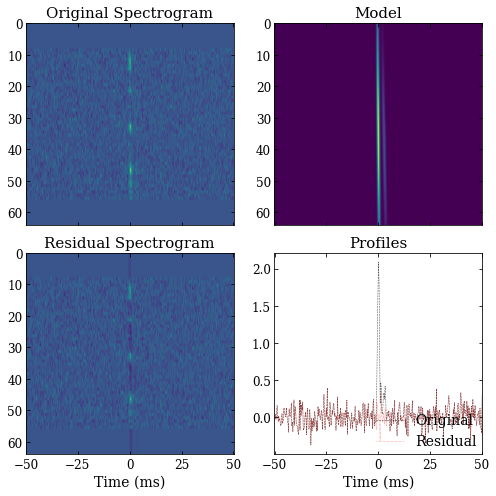

2021-12-09 02:29:17,654 - model -burstfit.fit - INFO - Making model.
2021-12-09 02:29:17,655 - model -burstfit.fit - INFO - Found 2 components.
2021-12-09 02:29:17,663 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-12-09 02:29:17,664 - get_off_pulse_region -burstfit.fit - INFO - Using sgram all-component-fit parameters.
2021-12-09 02:29:17,665 - model -burstfit.fit - INFO - Making model.
2021-12-09 02:29:17,666 - model -burstfit.fit - INFO - Found 2 components.
2021-12-09 02:29:17,672 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.034626043335317
2021-12-09 02:29:17,673 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-12-09 02:29:17,674 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-12-09 02:29:17,678 - tests -root - INFO - P values: T-test (0.55144), Kruskal (0.35204), KS (0.73246), F-test (0.95659)
2021-12-09 02:29

In [44]:
bf.fitall(plot=True)

The logging above shows the results of the statistical tests performed to compare the ON pulse residual with OFF pulse regions. Both the Left and Right off pulse regions were found to be statistically similar to ON pulse residual, and therefore the fitting was terminated. 

Again, the parameters can be accessed using `sgram_params`. The final parameters are saved in "all" key. This is useful in case of multiple components. In that case, individual component number will show the fit results for inidividual component, while "all" will give the result of fitting all the components together. In this case, we just had one component, so `fit_all_components` wasn't used, and therefore key "1" and "all" have same parameters. 

In [45]:
bf.sgram_params['all']

{1: {'popt': [34.731077234521564,
   24.614738100521752,
   722.5553999376341,
   189.31690144050543,
   1.447964900638764,
   0.44510496133672933,
   57.03561557477523],
  'perr': array([ 1.49956944,  2.00384114, 48.84110152,  0.33387409,  0.15857284,
          0.32424835,  0.12663847])},
 2: {'popt': [39.269836007916965,
   18.60515602404546,
   150.95994203276115,
   198.49099640131794,
   1.8227710368796342,
   0.22053030407561502,
   58.210165922811974],
  'perr': array([4.31412121e+00, 5.03682526e+00, 3.24646646e+01, 2.59689234e-01,
         3.08886480e-02, 3.44324529e-04, 1.68785716e-01])}}

## Plotting Results 

We can also plot the model, sgram and residuals

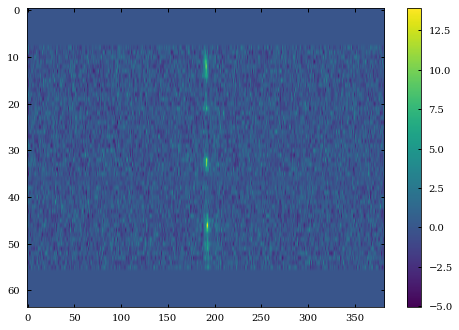

In [46]:
plot_me(bf.sgram)

2021-12-09 02:29:18,136 - model -burstfit.fit - INFO - Making model.
2021-12-09 02:29:18,138 - model -burstfit.fit - INFO - Found 2 components.


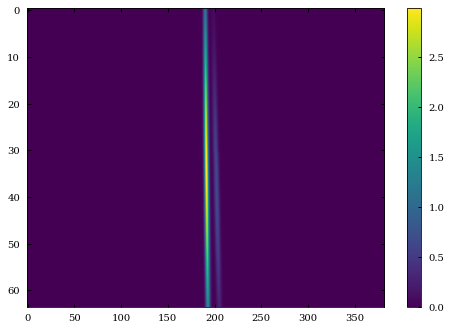

In [47]:
plot_me(bf.model)

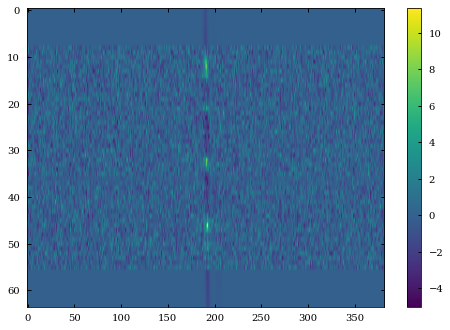

In [48]:
plot_me(bf.residual)

There are two ways of visualising plotting results using multi-panel plots. Using `plot_2d_fit` and `plot_fit_results`

In [49]:
from burstfit.utils.plotter import plot_2d_fit, plot_fit_results

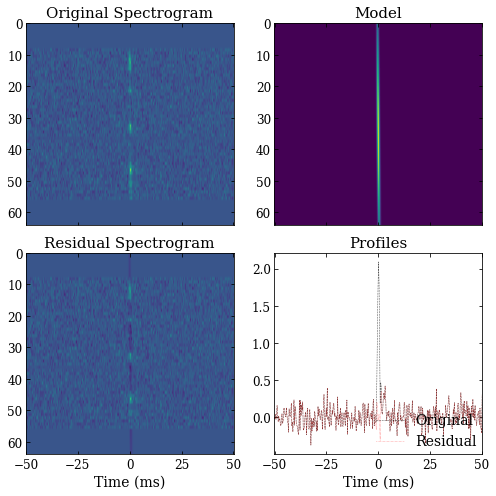

In [50]:
plot_2d_fit(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
            bf.tsamp, show=True, save=False)

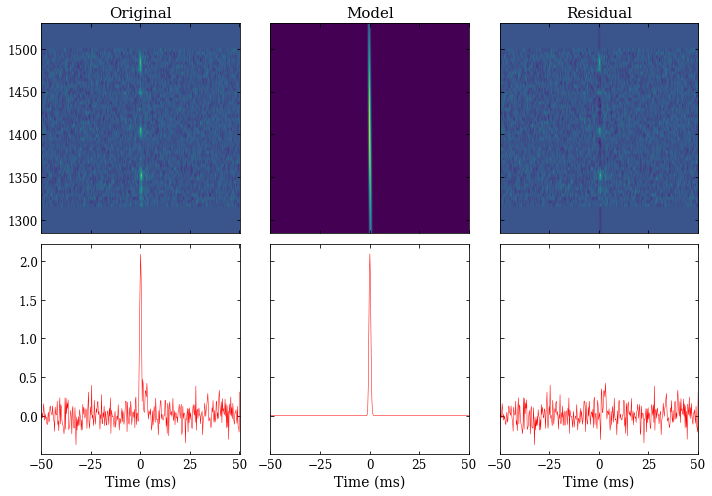

In [51]:
plot_fit_results(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
                 bf.tsamp, bf.fch1, bf.foff, show=True, save=False)

Now, to save the fitting results we can use `BurstIO` class. See this notebook.  